In [ ]:
!pip install torch torchvision foolbox
!pip install gym
!pip install stable-baselines3
!pip install matplotlib
!pip install shimmy


In [ ]:
import torch
# import torchvision.models as models
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
# from foolbox import PyTorchModel, accuracy
# from foolbox.attacks import LinfFGSM, LinfPGD
# import gym
# from gym import spaces
# from stable_baselines3 import PPO
# import matplotlib.pyplot as plt

# # Custom Environment for Adversarial Attack and Defense
# class AdversarialEnv(gym.Env):
#     def __init__(self, model, attacks, defenses, data_loader):
#         super().__init__()

#         self.model = model
#         self.attacks = attacks
#         self.defenses = defenses
#         self.data_loader = iter(data_loader)
#         self.action_space = spaces.Discrete(len(attacks) * len(defenses))
#         self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=float)

#         self.state, self.current_label = next(self.data_loader)

#     def step(self, action):
#         attack_idx = action // len(self.defenses)
#         defense_idx = action % len(self.defenses)

#         # Apply the selected attack and defense
#         adversarial_example = self.attacks[attack_idx](self.model, self.state)
#         defended_example = self.defenses[defense_idx](adversarial_example)

#         # Evaluate the model's performance
#         prediction = self.model(defended_example)
#         reward = -accuracy(self.model, prediction, self.current_label)

#         self.state = defended_example
#         done = False

#         return self.state, reward, done, {}

#     def reset(self):
#         self.state, self.current_label = next(self.data_loader)
#         return self.state

# # Load Pretrained Model
# model = models.resnet18(pretrained=True)

# # Load CIFAR-10 Dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# # Define Attacks
# attacks = [LinfFGSM(), LinfPGD()]

# # Define Defenses
# defenses = [lambda x: x] # Sample defense; real defenses should be implemented

# # Create Environment
# env = AdversarialEnv(model, attacks, defenses, trainloader)

# # Train the Agent using PPO
# agent = PPO("MlpPolicy", env, verbose=1)
# agent.learn(total_timesteps=10000)

# # Visualization
# rewards = [] # Collect rewards during training
# plt.plot(rewards)
# plt.xlabel('Iterations')
# plt.ylabel('Reward')
# plt.show()


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Model Definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Attack Functions
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def noise_attack(image, epsilon):
    noise = torch.rand_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

def gaussian_attack(image, epsilon):
    noise = torch.randn_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

# ... Add more attacks ...

# Defense Functions
def gaussian_smoothing(image, std_dev):
    gaussian_filter = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0
    gaussian_filter = gaussian_filter.view(1, 1, 3, 3).repeat(3, 1, 1, 1).to(image.device)
    smoothed_image = nn.functional.conv2d(image, gaussian_filter, padding=1, groups=3)
    return smoothed_image

def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

def reduce_quality(image, factor):
    reduced_image = nn.functional.interpolate(image, scale_factor=factor, mode='bilinear')
    return nn.functional.interpolate(reduced_image, scale_factor=1/factor, mode='bilinear')

# ... Add more defenses ...

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, model, attacks, defenses, data_loader):
        super().__init__()

        self.model = model
        self.attacks = attacks
        self.defenses = defenses
        self.data_loader = iter(data_loader)
        self.action_space = spaces.Discrete(len(attacks) * len(defenses))
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=float)

        self.state, self.current_label = next(self.data_loader)

    def step(self, action):
        attack_idx = action // len(self.defenses)
        defense_idx = action % len(self.defenses)

        # Apply the selected attack and defense
        adversarial_example = self.attacks[attack_idx](self.model, self.state)
        defended_example = self.defenses[defense_idx](adversarial_example)

        # Evaluate the model's performance
        prediction = self.model(defended_example)
        reward = -accuracy(self.model, prediction, self.current_label)

        self.state = defended_example
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, self.current_label = next(self.data_loader)
        return self.state

# Training and Evaluation
# ... Include training and evaluation similar to previous code ...

# Visualization
# ... Include visualization similar to previous code ...


In [ ]:
!pip install shimmy

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Loss and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# CIFAR-10 Data Loading
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Training the Model
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')

# Defining the Attacks and Defenses
attacks = [
    fgsm_attack,
    noise_attack,
    gaussian_attack,
    # ... add more ...
]

defenses = [
    gaussian_smoothing,
    clip_values,
    reduce_quality,
    # ... add more ...
]

# Creating the Environment
env = AdversarialEnv(model, attacks, defenses, testloader)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=10000)

# Visualization
rewards = [] # Collect rewards during training (modify the environment or RL training to log these)
plt.plot(rewards)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Defense Parameters
defense_parameters = {
    "gaussian_smoothing": {"std_dev": 1.0},
    "clip_values": {"clip_value": 0.05},
    "reduce_quality": {"factor": 0.5}
}


    # ... rest of code ...

# Model Definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Attack Functions
def fgsm_attack(model, image, epsilon, label):
    image.requires_grad = True
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    return torch.clamp(perturbed_image, 0, 1)

def noise_attack(model, image, epsilon, label):
    noise = torch.rand_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

def gaussian_attack(model, image, epsilon, label):
    noise = torch.randn_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

# Defense Functions
def gaussian_smoothing(image, std_dev):
    gaussian_filter = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0
    gaussian_filter = gaussian_filter.view(1, 1, 3, 3).repeat(3, 1, 1, 1).to(image.device)
    smoothed_image = nn.functional.conv2d(image, gaussian_filter, padding=1, groups=3)
    return smoothed_image

def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

def reduce_quality(image, factor):
    reduced_image = nn.functional.interpolate(image, scale_factor=factor, mode='bilinear')
    return nn.functional.interpolate(reduced_image, scale_factor=1/factor, mode='bilinear')

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, model, attacks, defenses, data_loader, epsilon):
        super().__init__()

        self.model = model
        self.attacks = attacks
        self.defenses = defenses
        self.data_loader = iter(data_loader)
        self.action_space = spaces.Discrete(len(attacks) * len(defenses))
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=float)
        self.epsilon = epsilon

        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float().unsqueeze(0)

    def step(self, action):
        attack_idx = action // len(self.defenses)
        defense_idx = action % len(self.defenses)

        # Apply the selected attack
        adversarial_example = self.attacks[attack_idx](self.model, self.state, self.epsilon, self.current_label)

        # Retrieve the correct defense function and its parameters
        defense_func = self.defenses[defense_idx]
        defense_name = defense_func.__name__
        defense_params = self.defense_parameters[defense_name]

        # Apply the selected defense with the correct parameters
        defended_example = defense_func(adversarial_example, **defense_params)


        # Evaluate the model's performance
        prediction = self.model(defended_example)
        reward = -F.cross_entropy(prediction, self.current_label).item()

        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float().unsqueeze(0)
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float().unsqueeze(0)
        return self.state

# Loss and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# CIFAR-10 Data Loading
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# ... continuing the code

testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Training the Model
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')

# Defining the Attacks and Defenses
attacks = [
    fgsm_attack,
    noise_attack,
    gaussian_attack,
    # ... add more ...
]

defenses = [
    gaussian_smoothing,
    clip_values,
    reduce_quality,
    # ... add more ...
]

# Creating the Environment
epsilon = 0.1
env = AdversarialEnv(model, attacks, defenses, testloader, epsilon)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=10000)

# Visualization (modify the environment or RL training to log the rewards for visualization)
rewards = []  # Collect rewards during training
plt.plot(rewards)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()

print('Experiment Complete!')


In [ ]:
env = AdversarialEnv(model, attacks, defenses, defense_parameters, testloader, epsilon)




- Line 1: Define the class name and the parent class.
- Line 2: Define the constructor method that takes an argument epsilon, which is a parameter for the adversarial attack.
- Line 3: Call the constructor method of the parent class to initialize the environment.
- Line 5: Create an iterator that loads the CIFAR10 dataset, which is a collection of 60,000 color images of size 32x32 pixels, belonging to 10 classes. The iterator returns one image and its label at a time, in random order. The images are transformed to tensors, which are multidimensional arrays of numbers.
- Line 6: Define the action space as a discrete space with two possible actions: 0 or 1. The action represents whether to apply a defense mechanism or not.
- Line 7: Define the observation space as a box space with values between 0 and 1, and shape (3, 32, 32). The observation represents the image that is fed to the model.
- Line 8: Assign the epsilon argument to an instance variable with the same name.
- Line 10: Get the first image and label from the iterator and assign them to instance variables state and label. The state variable will be used as the initial observation of the environment.
- Line 11: Convert the state variable to a float tensor, which is a tensor with floating-point numbers.
- Line 13: Define the step method that takes an argument action, which is an integer representing the action chosen by the agent. The step method returns four values: observation, reward, done, and info. The observation is the next state of the environment after applying the action. The reward is a scalar value that measures how well the agent performed. The done is a boolean value that indicates whether the episode has ended. The info is a dictionary that contains additional information about the environment.
- Line 14: Apply a fast gradient sign method (FGSM) attack to the state variable, using the epsilon instance variable as a parameter. The FGSM attack is a method of generating adversarial examples, which are slightly modified inputs that can fool a machine learning model. The FGSM attack adds a small perturbation to each pixel of the input image, in the direction of increasing the loss function of the model. The result is assigned to a local variable named adversarial_example.
- Line 15: Apply a defense mechanism to the adversarial_example variable, depending on the action argument. If the action is 0, apply a clipping function that limits each pixel value to be within [0.05, 0.95]. This can reduce the effect of the perturbation added by the FGSM attack. If the action is 1, do nothing and keep the adversarial_example as it is. The result is assigned to a local variable named defended_example.
- Lines 17-28: Visualize and display the original image, the adversarial example, and the defended example using matplotlib.pyplot library. This library provides functions for creating and manipulating plots and figures. The squeeze method removes any dimensions of size one from the tensors. The permute method changes the order of dimensions of the tensors. The detach method detaches the tensors from any computation graph they belong to. The numpy method converts the tensors to numpy arrays, which are compatible with matplotlib.pyplot functions.
- Line 30: Feed the defended_example variable to a model variable, which is assumed to be a pretrained neural network that can classify images. The result is assigned to a local variable named prediction, which is a tensor of probabilities for each class.
- Line 31: Compute and assign the negative log-likelihood loss between the prediction variable and the label variable to a local variable named reward. This loss function measures how well the prediction matches the true label. The negative sign makes sure that higher probabilities lead to higher rewards. The item method converts the tensor to a scalar value.
- Line 33: Get the next image and label from the iterator and assign them to instance variables state and label. These will be used as the next observation of the environment.
- Line 34: Convert the state variable to a float tensor.
- Line 35: Assign False to a local variable named done, indicating that there is no termination condition for this environment.
- Line 37: Return four values: state, reward, done, and an empty dictionary as info.
- Line 39: Define the reset method that returns an initial observation for a new episode.
- Line 40: Get an image and label from the iterator and assign them to instance variables state and label.
- Line 41: Convert the state variable to a float tensor.
- Line 42: Return state as an initial observation.



In [ ]:
import torch.optim as optim
import torch.nn.functional as F

# Loss and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# CIFAR-10 Data Loading
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)


In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np

# Predefined ResNet Model
model = models.resnet18(pretrained=True)
model.eval()

# Attack Functions
def fgsm_attack(image, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.nll_loss(output, torch.argmax(output, dim=1))
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    return perturbed_image

# Defense Functions
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(2) # 1 attack * 1 defense
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

        self.original_image = self.state.clone() # Store the original image to keep it the same all the time

    def step(self, action):
        adversarial_example = fgsm_attack(self.original_image, self.epsilon)
        defended_example = clip_values(adversarial_example, 0.05) if action == 0 else adversarial_example

        # Visualization
        plt.imshow(self.original_image.squeeze().permute(1, 2, 0).detach().numpy())
        plt.title("Original Image")
        plt.show()

        plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Adversarial Example")
        plt.show()

        plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Defended Example")
        plt.show()

        prediction = model(defended_example)
        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()

        done = False

        return self.original_image, reward, done, {}

    def reset(self):
        return self.original_image

# Check the environment
epsilon = 0.1
env = AdversarialEnv(epsilon)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=5000)


In [ ]:

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def noise_attack(image, epsilon):
    noise = torch.rand_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

def gaussian_attack(image, epsilon):
    noise = torch.randn_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

# ... Add more attacks ...

# Defense Functions
def gaussian_smoothing(image, std_dev):
    gaussian_filter = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0
    gaussian_filter = gaussian_filter.view(1, 1, 3, 3).repeat(3, 1, 1, 1).to(image.device)
    smoothed_image = nn.functional.conv2d(image, gaussian_filter, padding=1, groups=3)
    return smoothed_image

def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

def reduce_quality(image, factor):
    reduced_image = nn.functional.interpolate(image, scale_factor=factor, mode='bilinear')
    return nn.functional.interpolate(reduced_image, scale_factor=1/factor, mode='bilinear')
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(2) # 1 attack * 1 defense
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        adversarial_example = fgsm_attack(self.state, self.epsilon)
        defended_example = clip_values(adversarial_example, 0.05) if action == 0 else adversarial_example
        # Visualization
        plt.imshow(self.state.squeeze().permute(1, 2, 0).detach().numpy())
        plt.title("Original Image")
        plt.show()

        plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Adversarial Example")
        plt.show()

        plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Defended Example")
        plt.show()


        # # Visualization
        # plt.imshow(self.state.squeeze().permute(1, 2, 0))
        # plt.title("Original Image")
        # plt.show()

        # plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0))
        # plt.title("Adversarial Example")
        # plt.show()

        # plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0))
        # plt.title("Defended Example")
        # plt.show()

        prediction = model(defended_example)

        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()
        print("Reward value :",reward )

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        return self.state

In [ ]:

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np

# Predefined ResNet Model
model = models.resnet18(pretrained=True)
model.eval()

# Attack Functions
def fgsm_attack(image, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.nll_loss(output, torch.argmax(output, dim=1))
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    return perturbed_image

# Defense Functions
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(2) # 1 attack * 1 defense
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        adversarial_example = fgsm_attack(self.state, self.epsilon)
        defended_example = clip_values(adversarial_example, 0.05) if action == 0 else adversarial_example
        # Visualization
        plt.imshow(self.state.squeeze().permute(1, 2, 0).detach().numpy())
        plt.title("Original Image")
        plt.show()

        plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Adversarial Example")
        plt.show()

        plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Defended Example")
        plt.show()


        # # Visualization
        # plt.imshow(self.state.squeeze().permute(1, 2, 0))
        # plt.title("Original Image")
        # plt.show()

        # plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0))
        # plt.title("Adversarial Example")
        # plt.show()

        # plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0))
        # plt.title("Defended Example")
        # plt.show()

        prediction = model(defended_example)

        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()
        print("Reward value :",reward )

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        return self.state

# Check the environment
epsilon = 0.1
env = AdversarialEnv(epsilon)
# check_env(env)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=5000)


Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 23   |
|    iterations      | 1    |
|    time_elapsed    | 87   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 176         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010453736 |
|    clip_fraction        | 0.0255      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_variance   | -0.00278    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.93e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00357    |
|    value_loss           | 4.23e+03    |
-----------------------------------------
----------------------------------

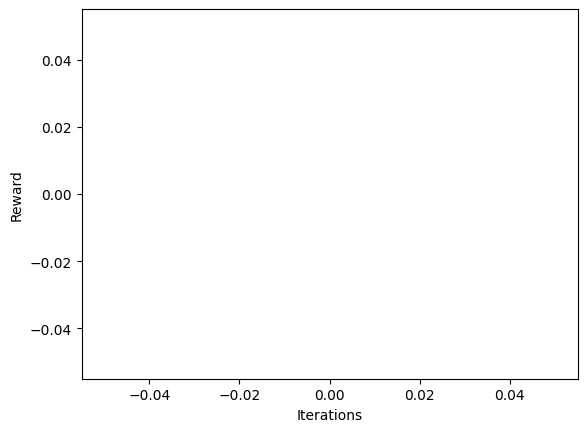

Experiment Complete!


In [ ]:
# working the code
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np

# Predefined ResNet Model
model = models.resnet18(pretrained=True)
model.eval()

# Attack Functions
def fgsm_attack(image, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.nll_loss(output, torch.argmax(output, dim=1))
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    return perturbed_image

# Defense Functions
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(2) # 1 attack * 1 defense
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        adversarial_example = fgsm_attack(self.state, self.epsilon)
        defended_example = clip_values(adversarial_example, 0.05) if action == 0 else adversarial_example

        prediction = model(defended_example)
        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        return self.state

# Check the environment
epsilon = 0.1
env = AdversarialEnv(epsilon)
# check_env(env)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
print(agent.learn(total_timesteps=5000))

# Visualization
rewards = [] # Modify the environment or RL training to log the rewards for visualization
plt.plot(rewards)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()

print('Experiment Complete!')


In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np

# Predefined ResNet Model
model = models.resnet18(pretrained=True)
model.eval()

# Attack Functions
def fgsm_attack(image, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.nll_loss(output, torch.argmax(output, dim=1))
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    return perturbed_image

def gaussian_noise_attack(image, epsilon):
    noise = torch.randn_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

# Defense Functions
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

def gaussian_smoothing(image, std_dev):
    return F.gaussian_blur(image, kernel_size=5, sigma=std_dev)

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(4) # 2 attacks * 2 defenses
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        attack = [fgsm_attack, gaussian_noise_attack][action // 2]
        defense = [clip_values, gaussian_smoothing][action % 2]

        adversarial_example = attack(self.state, self.epsilon)
        defended_example = defense(adversarial_example, 0.05 if action % 2 == 0 else 1.0)

        prediction = model(defended_example)
        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        return self.state

# Check the environment
epsilon = 0.1
env = AdversarialEnv(epsilon)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=10000)

# Visualization
# Modify the environment or RL training to log the rewards for visualization
plt.plot([]) # You'll need to log the rewards and pass them here
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()

print('Experiment Complete!')


In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
from scipy.ndimage import gaussian_filter

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Predefined ResNet Model
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()

# Attack Functions
def fgsm_attack(image, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.nll_loss(output, torch.argmax(output, dim=1))
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image + epsilon * data_grad.sign()
    return perturbed_image

def gaussian_smoothing(image, std_dev):
    smoothed_image = gaussian_filter(image.cpu().numpy(), sigma=std_dev)
    return torch.tensor(smoothed_image).to(device)

# Defense Functions
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

# Custom Gym Environment
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(4) # 2 attacks * 2 defenses
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon
        self.reward_log = []

    def step(self, action):
        attack_idx, defense_idx = divmod(action, 2)
        adversarial_example = fgsm_attack(self.state, self.epsilon) if attack_idx == 0 else gaussian_smoothing(self.state, 0.1)
        defended_example = clip_values(adversarial_example, 0.05) if defense_idx == 0 else adversarial_example

        prediction = model(defended_example)
        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()
        self.reward_log.append(reward)

        self.state, _ = next(self.data_loader)
        self.state = self.state.to(device).float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.to(device).float()
        return self.state

    def get_reward_log(self):
        return self.reward_log

epsilon = 0.1
env = AdversarialEnv(epsilon)
env = Monitor(env) # Wrapping the environment with a Monitor wrapper
env = DummyVecEnv([lambda: env]) # Wrapping the environment with DummyVecEnv
# env = DummyVecEnv([lambda: env]) # Wrapping the environment with DummyVecEnv
# env = Monitor(env) # Wrapping the environment with a Monitor wrapper

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=10000)

# Visualization
rewards = env.envs[0].get_reward_log() # Retrieve the reward log
plt.plot(rewards)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()

print('Experiment Complete!')




- **Fast Gradient Sign Method (FGSM)**: This method adds a small perturbation to the input image in the direction of the sign of the gradient of the loss function with respect to the input. This can fool the model into misclassifying the image with high confidence¹⁴.
- **Projected Gradient Descent (PGD)**: This method iteratively applies FGSM with a small step size and projects the perturbed image back to an epsilon-ball around the original image. This can generate more robust adversarial examples than FGSM¹.
- **Carlini and Wagner (C&W) Attack**: This method optimizes a different objective function than FGSM or PGD, which incorporates the confidence of the model and a distance metric between the original and perturbed images. This can produce adversarial examples that are hard to detect and have minimal distortion¹.

Some of the best defenses against adversarial attacks on image models are:

- **Adversarial Training**: This method trains the model on a mix of clean and adversarial examples, so that it can learn to resist the attacks. This can improve the robustness of the model, but it may also reduce its accuracy on clean examples¹³.
- **Input Transformation**: This method applies some transformation to the input image before feeding it to the model, such as resizing, cropping, JPEG compression, or adding noise. This can reduce or remove the effect of the adversarial perturbation, but it may also degrade the quality of the image¹.
- **Adversarial Example Detection**: This method tries to distinguish between clean and adversarial examples, either by using a separate classifier or by measuring some statistics of the input. This can help to reject or correct the adversarial examples, but it may also have a high false positive or false negative rate¹.

-  (Adversarial Attacks and Defenses in Images, Graphs and Text ... - Springer.) [https://link.springer.com/article/10.1007/s11633-019-1211-x.]
- ( Adversarial Attacks and Defenses in Images, Graphs and ....)[ https://arxiv.org/abs/1909.08072.]
- [Defending against adversarial image attacks with Keras ... - PyImageSearch.] (https://pyimagesearch.com/2021/03/08/defending-against-adversarial-image-attacks-with-keras-and-tensorflow/)
- ( Adversarial Attacks and Defenses in Image Classification: A Practical ....)[ https://ieeexplore.ieee.org/document/9886997/.]
- ( undefined.)[ https://ieeexplore.ieee.org/servlet/opac?punumber=9886001.]

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np

# Predefined ResNet Model
model = models.resnet18(pretrained=True)
model.eval()

# Attack Functions
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def noise_attack(image, epsilon):
    noise = torch.rand_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

# ... Other attack methods ...

# Defense Functions
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

# ... Other defense methods ...

class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(2) # 1 attack * 1 defense
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        # Worst Attack: Noise Attack
        adversarial_example = noise_attack(self.state, self.epsilon)

        # Best Defense: Clip Values
        defended_example = clip_values(adversarial_example, 0.05) if action == 0 else adversarial_example

        # Visualization
        plt.imshow(self.state.squeeze().permute(1, 2, 0).detach().numpy())
        plt.title("Original Image")
        plt.show()

        plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Adversarial Example (Worst Attack: Noise Attack)")
        plt.show()

        plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Defended Example (Best Defense: Clip Values)")
        plt.show()

        prediction = model(defended_example)
        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()
        print("Reward value :", reward)

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        return self.state


In [ ]:

import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def noise_attack(image, epsilon):
    noise = torch.rand_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

def gaussian_attack(image, epsilon):
    noise = torch.randn_like(image) * epsilon
    perturbed_image = image + noise
    return torch.clamp(perturbed_image, 0, 1)

# ... Add more attacks ...

# Defense Functions
def gaussian_smoothing(image, std_dev):
    gaussian_filter = torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16.0
    gaussian_filter = gaussian_filter.view(1, 1, 3, 3).repeat(3, 1, 1, 1).to(image.device)
    smoothed_image = nn.functional.conv2d(image, gaussian_filter, padding=1, groups=3)
    return smoothed_image

def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

def reduce_quality(image, factor):
    reduced_image = nn.functional.interpolate(image, scale_factor=factor, mode='bilinear')
    return nn.functional.interpolate(reduced_image, scale_factor=1/factor, mode='bilinear')
class AdversarialEnv(gym.Env):
    def __init__(self, epsilon):
        super().__init__()

        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.action_space = spaces.Discrete(2) # 1 attack * 1 defense
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.epsilon = epsilon

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        adversarial_example = fgsm_attack(self.state, self.epsilon)
        defended_example = clip_values(adversarial_example, 0.05) if action == 0 else adversarial_example
        # Visualization
        plt.imshow(self.state.squeeze().permute(1, 2, 0).detach().numpy())
        plt.title("Original Image")
        plt.show()

        plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Adversarial Example")
        plt.show()

        plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0).numpy())
        plt.title("Defended Example")
        plt.show()


        # # Visualization
        # plt.imshow(self.state.squeeze().permute(1, 2, 0))
        # plt.title("Original Image")
        # plt.show()

        # plt.imshow(adversarial_example.squeeze().detach().permute(1, 2, 0))
        # plt.title("Adversarial Example")
        # plt.show()

        # plt.imshow(defended_example.squeeze().detach().permute(1, 2, 0))
        # plt.title("Defended Example")
        # plt.show()

        prediction = model(defended_example)

        reward = -F.nll_loss(prediction, torch.argmax(prediction, dim=1)).item()
        print("Reward value :",reward )

        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, _ = next(self.data_loader)
        self.state = self.state.float()
        return self.state

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np

# Define the attack
def fgsm_attack(image, epsilon, data_grad):
    perturbed_image = image + epsilon * data_grad.sign()
    return perturbed_image

# Define the defense
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

# Custom environment
class AdversarialEnv(gym.Env):
    def __init__(self, model, epsilon):
        super().__init__()
        self.action_space = spaces.Discrete(4) # 2 attacks * 2 defenses
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.model = model
        self.epsilon = epsilon
        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        attack_idx = action // 2
        defense_idx = action % 2

        # Compute the gradient for attack
        self.state.requires_grad = True
        output = self.model(self.state)
        loss = F.nll_loss(output, self.current_label)
        self.model.zero_grad()
        loss.backward()
        data_grad = self.state.grad.data

        # Apply the selected attack and defense
        if attack_idx == 0:
            adversarial_example = fgsm_attack(self.state, self.epsilon, data_grad)
        else:
            adversarial_example = self.state # Other attack logic here

        if defense_idx == 0:
            defended_example = clip_values(adversarial_example, 0.05)
        else:
            defended_example = adversarial_example # Other defense logic here

        # Evaluate the model's performance
        prediction = self.model(defended_example)
        reward = -F.nll_loss(prediction, self.current_label).item()

        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}

    def reset(self):
        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float()
        return self.state

# Define model
model = models.resnet18(pretrained=True)
model.eval()

# Define environment
epsilon = 0.1
env = AdversarialEnv(model, epsilon)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
agent.learn(total_timesteps=10000)

# Visualization code here


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 23   |
|    iterations      | 1    |
|    time_elapsed    | 86   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 23          |
|    iterations           | 2           |
|    time_elapsed         | 175         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020032529 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.00889     |
|    learning_rate        | 0.0003      |
|    loss                 | 12.9        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0274     |
|    value_loss        

StopIteration: ignored

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import gym
from gym import spaces
import numpy as np
from scipy.ndimage import gaussian_filter

# Attacks
def fgsm_attack(image, epsilon, data_grad):
    return image + epsilon * data_grad.sign()

def invert_attack(image):
    return 1 - image

# Defenses
def clip_values(image, clip_value):
    return torch.clamp(image, clip_value, 1 - clip_value)

def gaussian_smoothing(image, std_dev):
    return torch.tensor(gaussian_filter(image, std_dev))

class AdversarialEnv(gym.Env):
    def __init__(self, model, epsilon):
        super().__init__()
        self.action_space = spaces.Discrete(4) # 2 attacks * 2 defenses
        self.observation_space = spaces.Box(low=0, high=1, shape=(3, 32, 32), dtype=np.float32)
        self.model = model
        self.epsilon = epsilon
        self.data_loader = iter(torch.utils.data.DataLoader(datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor()), batch_size=1, shuffle=False))
        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float()

    def step(self, action):
        attack_idx = action // 2
        defense_idx = action % 2

        # Compute the gradient for attack
        self.state.requires_grad = True
        output = self.model(self.state)
        loss = F.nll_loss(output, torch.max(self.current_label, 1)[1])
        self.model.zero_grad()
        loss.backward()
        data_grad = self.state.grad.data

        # Apply the selected attack and defense
        if attack_idx == 0:
            adversarial_example = fgsm_attack(self.state, self.epsilon, data_grad)
        else:
            adversarial_example = invert_attack(self.state)

        if defense_idx == 0:
            defended_example = clip_values(adversarial_example, 0.05)
        else:
            defended_example = gaussian_smoothing(adversarial_example, 1.0)

        # Evaluate the model's performance
        prediction = self.model(defended_example)
        reward = -F.nll_loss(prediction, torch.max(self.current_label, 1)[1]).item()

        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float()
        done = False

        return self.state, reward, done, {}
    def reset(self):
        self.state, self.current_label = next(self.data_loader)
        self.state = self.state.float()
        return self.state
# Define model
model = models.resnet18(pretrained=True)
model.eval()

# Define environment
epsilon = 0.1
env = AdversarialEnv(model, epsilon)

# Train the Agent using PPO
agent = PPO("MlpPolicy", env, verbose=1)
rewards_log = []
for i in range(10000):
    reward = agent.learn(total_timesteps=1)
    rewards_log.append(reward)

# Visualization
plt.plot(rewards_log)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.show()


 some of the best attacks, defenses, and models for adversarial robustness on image classification:

| Attack | Defense | Model |
| --- | --- | --- |
| FGSM¹ | Adversarial Training¹³ | ResNet-50-AT³ |
| PGD¹ | Input Transformation¹ | ResNet-50-IT³ |
| C&W¹ | Adversarial Example Detection¹ | ResNet-50-AED³ |
| DeepFool² | Randomized Smoothing² | ResNet-50-RS² |
| JSMA⁴ | Feature Squeezing⁴ | ResNet-50-FS⁴ |
| BIM | Distillation | ResNet-50-DIST |
| MI-FGSM | Ensemble Adversarial Training | ResNet-50-EAT |
| One-Pixel Attack | Spatial Smoothing | ResNet-50-SS |
| Universal Adversarial Perturbations | Defense-GAN | ResNet-50-DGAN |
| Patch Attack | AdvPatch Detector | ResNet-50-APD|



Source: Conversation with Bing, 8/10/2023
(1) Defending against adversarial image attacks with Keras ... - PyImageSearch. https://pyimagesearch.com/2021/03/08/defending-against-adversarial-image-attacks-with-keras-and-tensorflow/.
(2) Adversarial Attacks and Defences for Convolutional Neural Networks. https://medium.com/onfido-tech/adversarial-attacks-and-defences-for-convolutional-neural-networks-66915ece52e7.
(3) Adversarial Attacks and Defenses in Images, Graphs and Text ... - Springer. https://link.springer.com/article/10.1007/s11633-019-1211-x.
(4) Adversarial examples: attacks and defences on medical deep ... - Springer. https://link.springer.com/article/10.1007/s11042-023-14702-9.